In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'batsong_segmented'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'fruitbat.pickle'

In [4]:
syllable_df = pd.read_pickle(df_loc)

In [5]:
syllable_df[:3]

,start_time,end_time,indv,indvi,context,key,rate,spectrogram
0,0.203,0.2790,-210,0,Threat-like,130116080549387242,250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.372,0.5065,-210,0,Threat-like,130116080549387242,250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.223,0.2465,-221,0,Sleeping,130303053329639859,250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [6]:
len(syllable_df)

407642

In [7]:
np.shape(syllable_df.spectrogram.values[0])

(32, 38)

In [8]:
len(syllable_df.indv.unique())

83

In [9]:
syllable_df['indv_nonneg'] = [i if '-' not in i else i[1:] for i in syllable_df.indv.values]

In [10]:
syllable_df.indv_nonneg.unique()

array(['210', '221', '214', '119', '111', '230', '0', '220', '211', '215',
       '216', '208', '120', '203', '207', '231', '228', '222', '226',
       '110', '109', '108', '105', '101', '213', '102', '233', '116',
       '115', '223', '204', '225', '107', '201', '112', '202', '113',
       '114', '205', '103', '218', '118'], dtype=object)

### project

(4771, 1216)


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


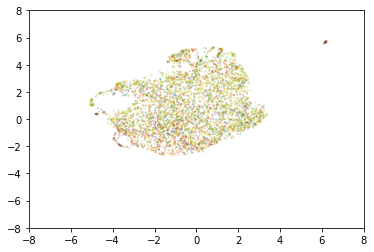

(2568, 1216)


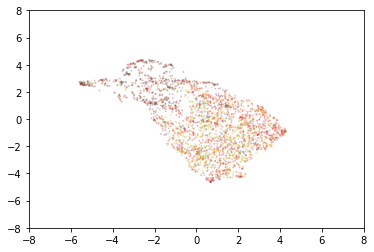

(483, 1216)


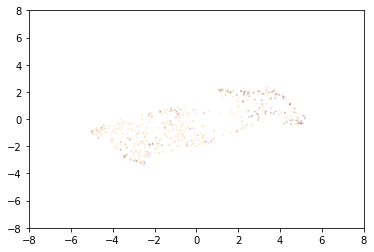

(3471, 1216)


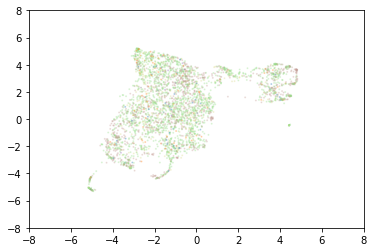

(6011, 1216)


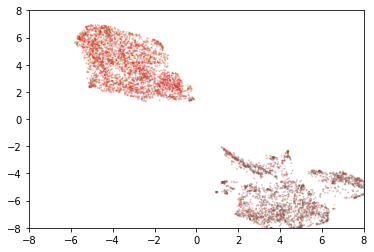

(17488, 1216)


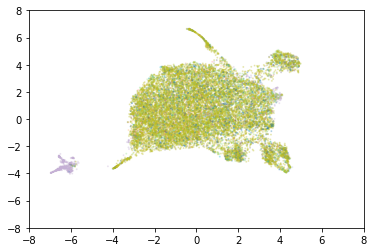

(38099, 1216)


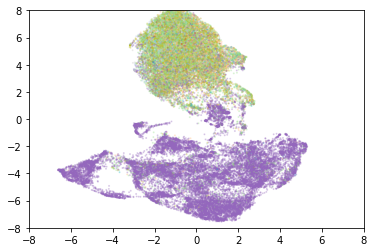

(4104, 1216)


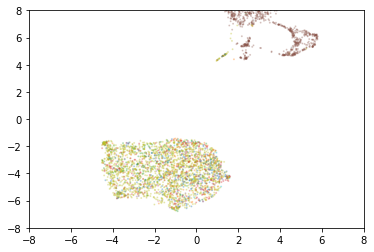

(6327, 1216)


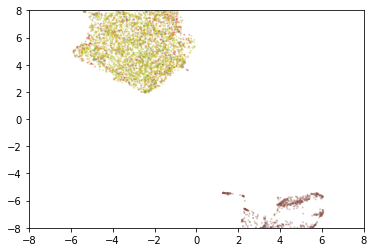

(21880, 1216)


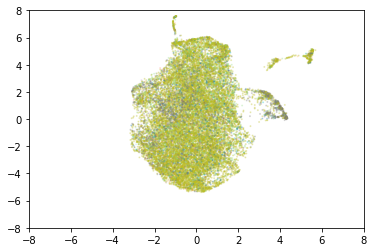

(10018, 1216)


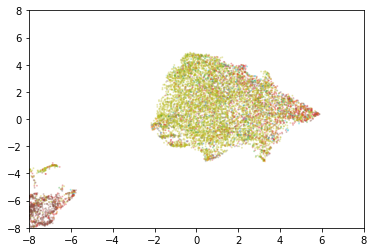

(2073, 1216)


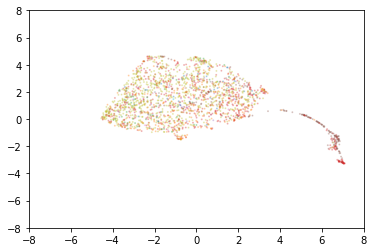

(2265, 1216)


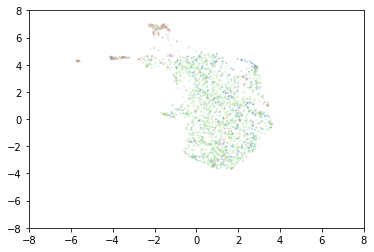

(2448, 1216)


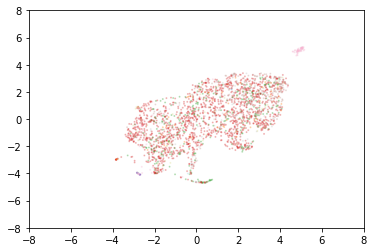

(3078, 1216)


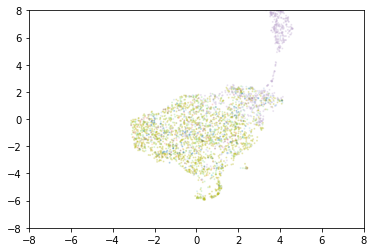

(14726, 1216)


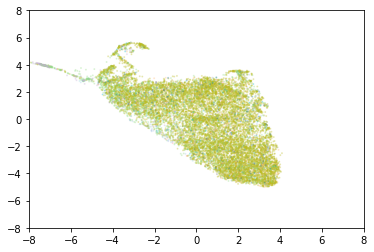

(12100, 1216)


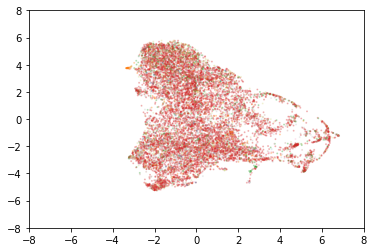

(852, 1216)


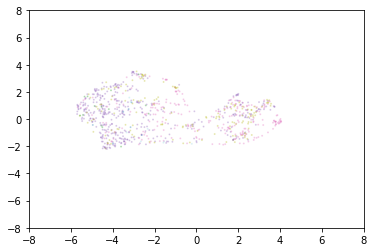

(13083, 1216)


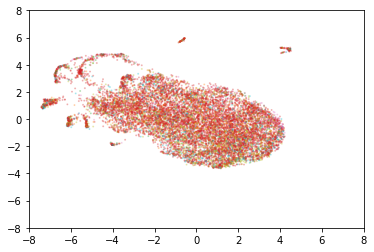

(4197, 1216)


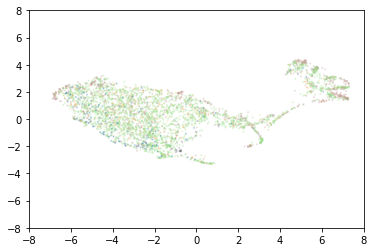

(5766, 1216)


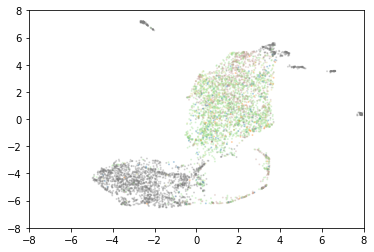

(1171, 1216)


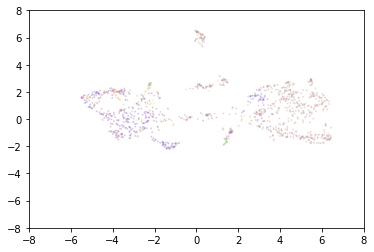

(287, 1216)


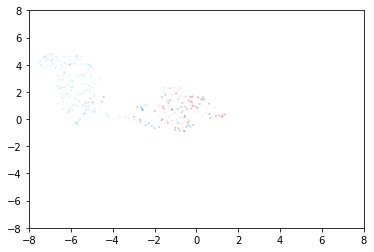

(710, 1216)


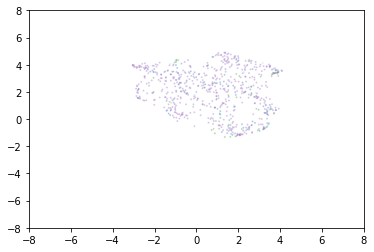

(7946, 1216)


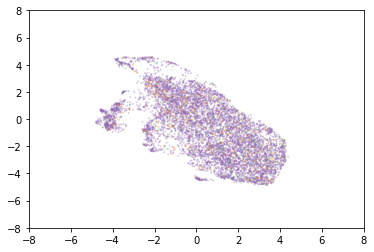

(1032, 1216)


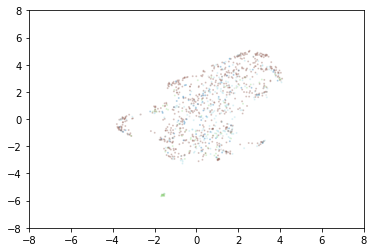

(771, 1216)


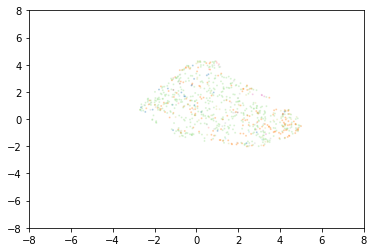

(537, 1216)


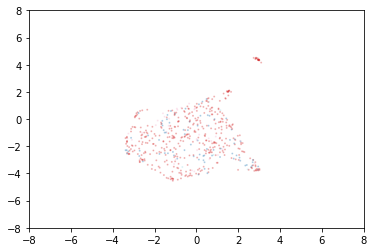

(1036, 1216)


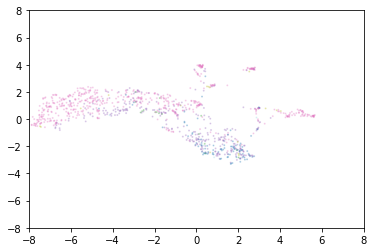

(251, 1216)


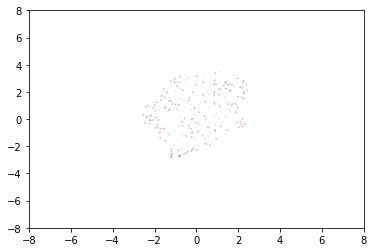

(6128, 1216)


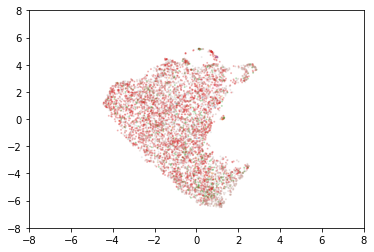

(1994, 1216)


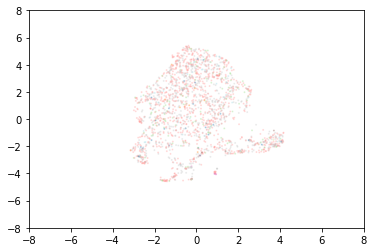

(784, 1216)


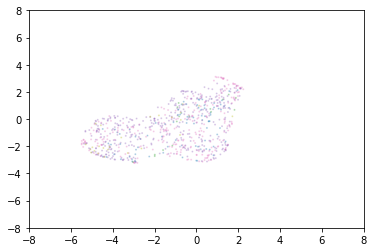

(4317, 1216)


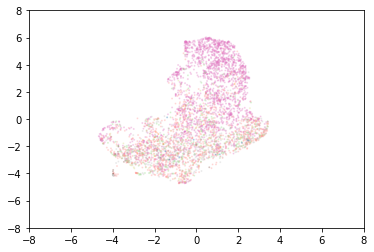

(1617, 1216)


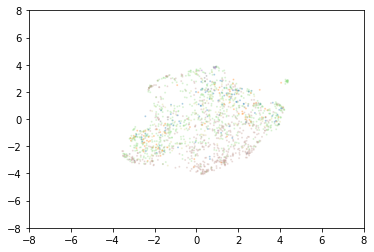

(879, 1216)


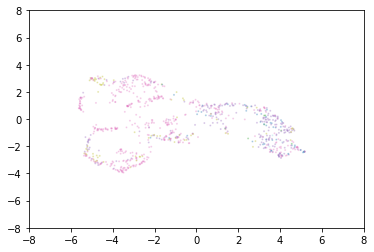

(765, 1216)


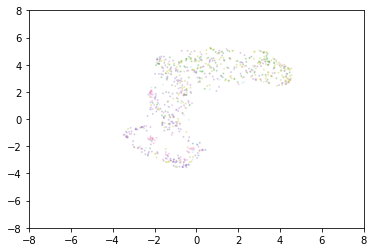

(823, 1216)


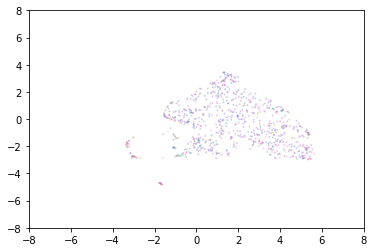

(1759, 1216)


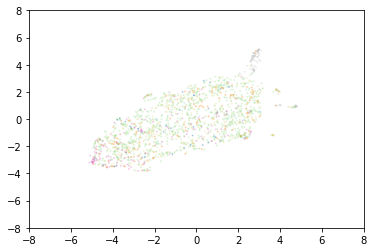

(235, 1216)


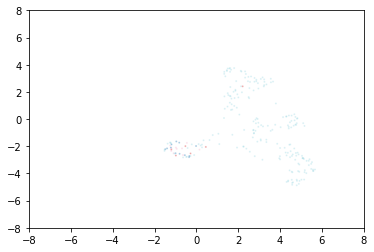

(312, 1216)


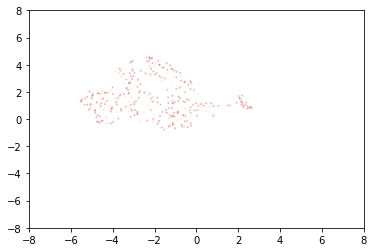

(311, 1216)


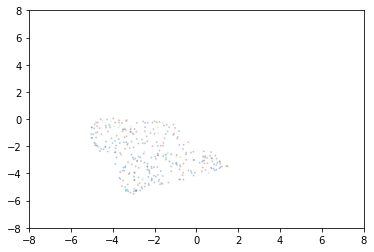

In [13]:
for indv in tqdm(syllable_df.indv_nonneg.unique()):
    subset_df = syllable_df[syllable_df.indv_nonneg == indv]
    
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in tqdm(specs)]
    specs_flattened = flatten_spectrograms(specs)
    print(np.shape(specs_flattened))
    
    cuml_umap = cumlUMAP()
    embedding = cuml_umap.fit_transform(specs_flattened)
    subset_df['umap'] = list(embedding)
    
    unique_labs = np.unique(subset_df.context.values)
    unique_labs_dict = {lab:i for i, lab in enumerate(unique_labs)}
    lab_list = [unique_labs_dict[i] for i in subset_df.context.values]
    fig, ax = plt.subplots()
    ax.scatter(embedding[:,0], embedding[:,1], s=1, c=lab_list, cmap=plt.cm.tab20, alpha = 0.25)
    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    plt.show()
    
    ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'indvs')
    subset_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / 'indvs' / (indv + '.pickle'))

### Save

In [11]:
ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'full')

In [12]:
syllable_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / 'full.pickle')